In [ ]:
from google.colab import drive
import numpy as np

In [ ]:
# Step 1: Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_path = "/content/drive/MyDrive/DATASET/Dataset/updated_dataset.npz"
data = np.load(output_path)

images = data['images']
labels = data['labels']


In [ ]:
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Images shape: (648, 224, 224, 3)
Labels shape: (648,)


In [ ]:
# Check the shape of the images
print("Images shape:", images.shape)

# Verify if the images have 3 channels
if images.shape[-1] == 3:
    print("Images are already in RGB format.")
else:
    print("Images need to be converted to RGB format.")


Images shape: (648, 224, 224, 3)
Images are already in RGB format.


In [ ]:
# Check the range of pixel values
print("Image pixel value range:", images.min(), "to", images.max())

if images.min() >= 0.0 and images.max() <= 1.0:
    print("Images are already normalized to [0, 1].")
else:
    print("Images need normalization to [0, 1].")


Image pixel value range: 0 to 255
Images need normalization to [0, 1].


In [ ]:
# Check the shape of the labels
print("Labels shape:", labels.shape)

# Verify if labels are one-hot encoded
if len(labels.shape) == 2 and labels.shape[1] == 3:
    print("Labels are already one-hot encoded with 3 classes.")
else:
    print("Labels need one-hot encoding.")


Labels shape: (648,)
Labels need one-hot encoding.


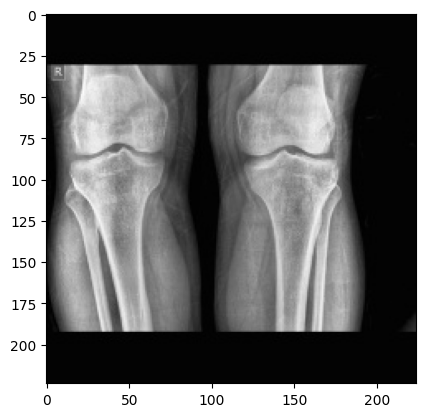

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(images[0])

In [ ]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Expand grayscale images to 3 channels if necessary
if images.shape[-1] != 3:
    images = np.stack([images] * 3, axis=-1)  # Shape: (num_samples, 224, 224, 3)

# Normalize pixel values to [0, 1]
images = images.astype('float32') / 255.0

# One-hot encode labels
labels = to_categorical(labels, num_classes=3)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (453, 224, 224, 3) (453, 3)
Validation set: (97, 224, 224, 3) (97, 3)
Test set: (98, 224, 224, 3) (98, 3)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# Load pre-trained ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build a Sequential model
model = Sequential()

# Add the pre-trained ResNet50 model (without the top layers)
model.add(base_model)

# Add Global Average Pooling layer
model.add(GlobalAveragePooling2D())

# Add Fully Connected layer
model.add(Dense(128, activation='relu'))

# Add the output layer with 3 classes
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


y_train shape: (453, 3)
y_val shape: (97, 3)


In [ ]:
# Reload the raw labels from your dataset to inspect them
raw_labels = data['labels']  # Replace with the correct key
print("Raw labels shape:", raw_labels.shape)
print("Unique values in raw labels:", np.unique(raw_labels))


Raw labels shape: (648,)
Unique values in raw labels: [0 1 2]


In [ ]:
# Convert string labels to integers
raw_labels = raw_labels.astype(int)
print("Converted labels:", raw_labels[:10])  # Display a few examples


Converted labels: [0 0 0 0 0 0 0 0 0 0]


In [ ]:
import numpy as np

# Check the unique class labels and their counts
unique, counts = np.unique(raw_labels, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class distribution:", class_distribution)


Class distribution: {0: 216, 1: 216, 2: 216}


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # You can adjust the number of epochs
    batch_size=32,  # Adjust based on your hardware
    verbose=1
)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 146s 9s/step - accuracy: 0.3245 - loss: 1.3869 - val_accuracy: 0.2990 - val_loss: 1.1355
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 111s 8s/step - accuracy: 0.3714 - loss: 1.1758 - val_accuracy: 0.3196 - val_loss: 1.1266
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 110s 7s/step - accuracy: 0.3543 - loss: 1.1372 - val_accuracy: 0.3196 - val_loss: 1.1395
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 0.3054 - loss: 1.1447 - val_accuracy: 0.3196 - val_loss: 1.1655
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 110s 7s/step - accuracy: 0.3524 - loss: 1.1393 - val_accuracy: 0.3093 - val_loss: 1.0899
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 161s 9s/step - accuracy: 0.3644 - loss: 1.0941 - val_accuracy: 0.3814 - val_loss: 1.0827
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 121s 7s/step - accuracy: 0.3701 - loss: 1.1096 - val_accuracy: 0.3814 - val_loss: 1.1096
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.3508 - loss: 1.1213 - val_accuracy: 0.3093 - v

In [ ]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", test_accuracy)




4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.3162 - loss: 1.1188
Test Accuracy: 0.30612245202064514


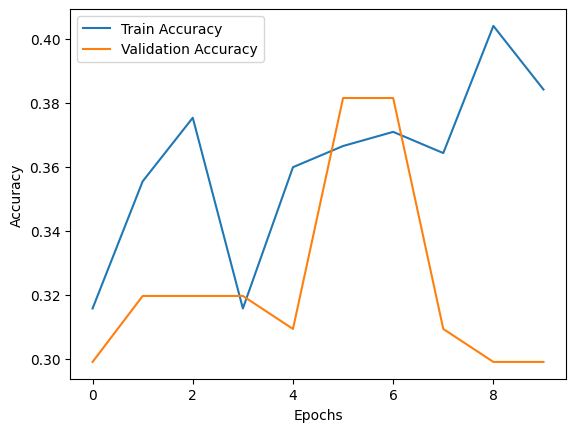

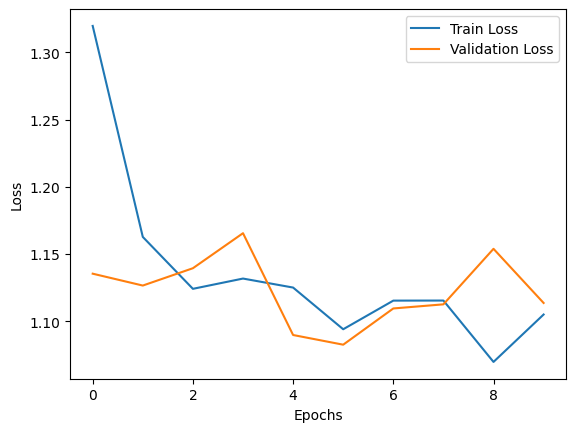

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import kagglehub
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

path = kagglehub.dataset_download("fuyadhasanbhoyan/knee-osteoarthritis-classification-224224")

classification_folder = os.path.join(path, 'Knee Osteoarthritis Classification')
train_path = os.path.join(classification_folder, 'train')
val_path = os.path.join(classification_folder, 'val')
test_path = os.path.join(classification_folder, 'test')

print(f"Train path: {train_path}")
print(f"Validation path: {val_path}")
print(f"Test path: {test_path}")





Train path: /kaggle/input/knee-osteoarthritis-classification-224224/Knee Osteoarthritis Classification/train
Validation path: /kaggle/input/knee-osteoarthritis-classification-224224/Knee Osteoarthritis Classification/val
Test path: /kaggle/input/knee-osteoarthritis-classification-224224/Knee Osteoarthritis Classification/test


In [ ]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3780 images belonging to 3 classes.
Found 1080 images belonging to 3 classes.
Found 540 images belonging to 3 classes.


In [ ]:

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.6)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
print("Training DenseNet121 model...")

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)


Training DenseNet121 model...
Epoch 1/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 60s 309ms/step - accuracy: 0.3352 - loss: 1.7712 - val_accuracy: 0.3074 - val_loss: 1.1935
Epoch 2/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.3490 - loss: 1.6144 - val_accuracy: 0.3231 - val_loss: 1.1450
Epoch 3/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.3638 - loss: 1.4521 - val_accuracy: 0.3519 - val_loss: 1.1117
Epoch 4/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.3638 - loss: 1.3810 - val_accuracy: 0.3667 - val_loss: 1.0883
Epoch 5/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.3712 - loss: 1.2999 - val_accuracy: 0.3917 - val_loss: 1.0710
Epoch 6/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.3688 - loss: 1.2490 - val_accuracy: 0.4139 - val_loss: 1.0585
Epoch 7/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.4057 - loss: 1.2065 - val_accuracy: 0.4454 - val_loss: 1.0466
Epoch 8/60
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/ste

<function DenseNet121 at 0x78670d5725c0> training complete! Model saved.


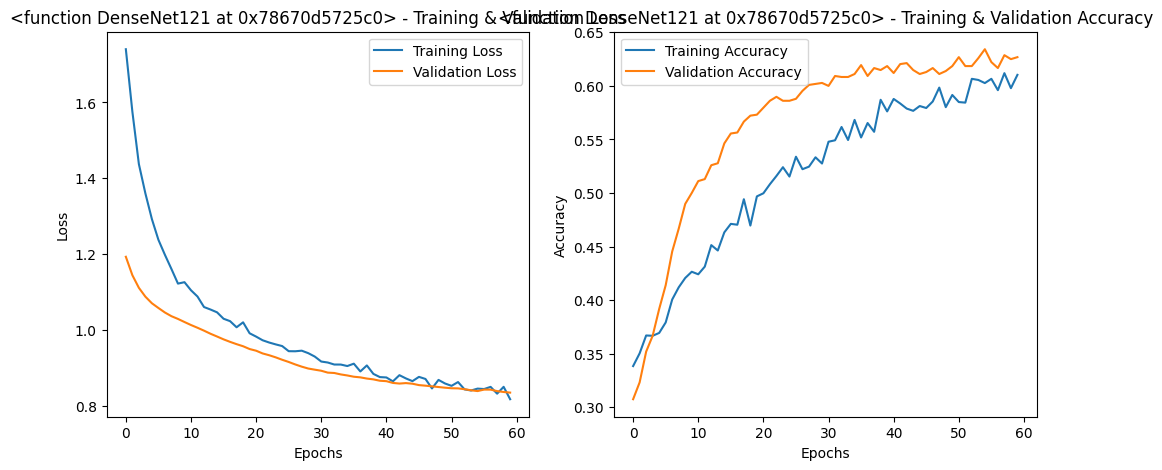

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 465ms/step - accuracy: 0.5081 - loss: 0.8488
Test Accuracy: 0.67
Test Loss: 0.75
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 646ms/step
Classification Report:

              precision    recall  f1-score   support

      Normal       0.83      0.45      0.58       180
  Osteopenia       0.72      0.81      0.76       180
Osteoporosis       0.56      0.74      0.64       180

    accuracy                           0.67       540
   macro avg       0.70      0.67      0.66       540
weighted avg       0.70      0.67      0.66       540



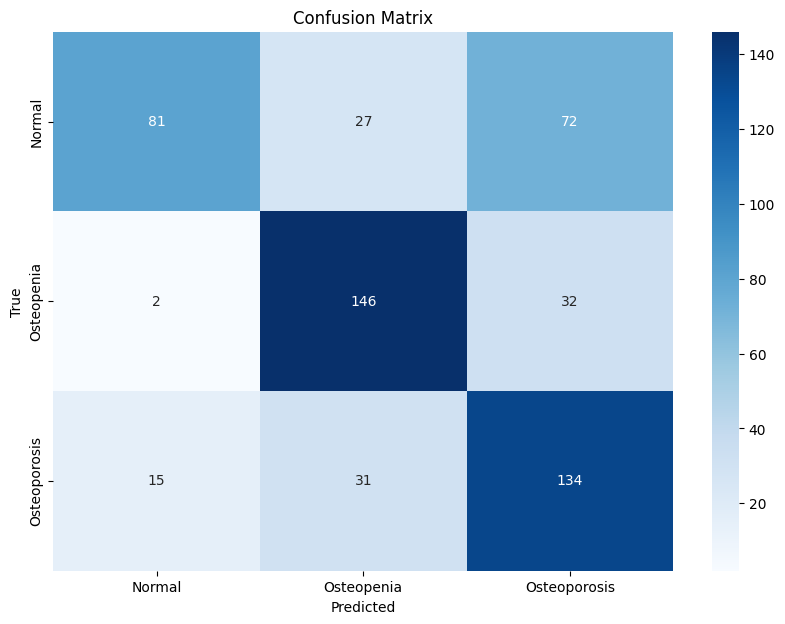

Loading <function DenseNet121 at 0x78670d5725c0> model...

Loaded <function DenseNet121 at 0x78670d5725c0> Model Architecture:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,924,555 (30.23 MB)

 Trainable params: 295,683 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 591,368 (2.26 MB)

NameError: name 'val_paths' is not defined

In [ ]:

model_name=DenseNet121

model.save(f"/content/{model_name}_KneeOsteo_DeepModel.keras")
print(f"{model_name} training complete! Model saved.")



plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f'{model_name} - Training & Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'{model_name} - Training & Validation Accuracy')

plt.show()



test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.2f}')
print(f'Test Loss: {test_loss:.2f}')

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))





cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print(f"Loading {model_name} model...")
loaded_model = tf.keras.models.load_model(f"/content/{model_name}_KneeOsteo_DeepModel.keras")
print(f"\nLoaded {model_name} Model Architecture:")
loaded_model.summary()



